## K-fold GMM model

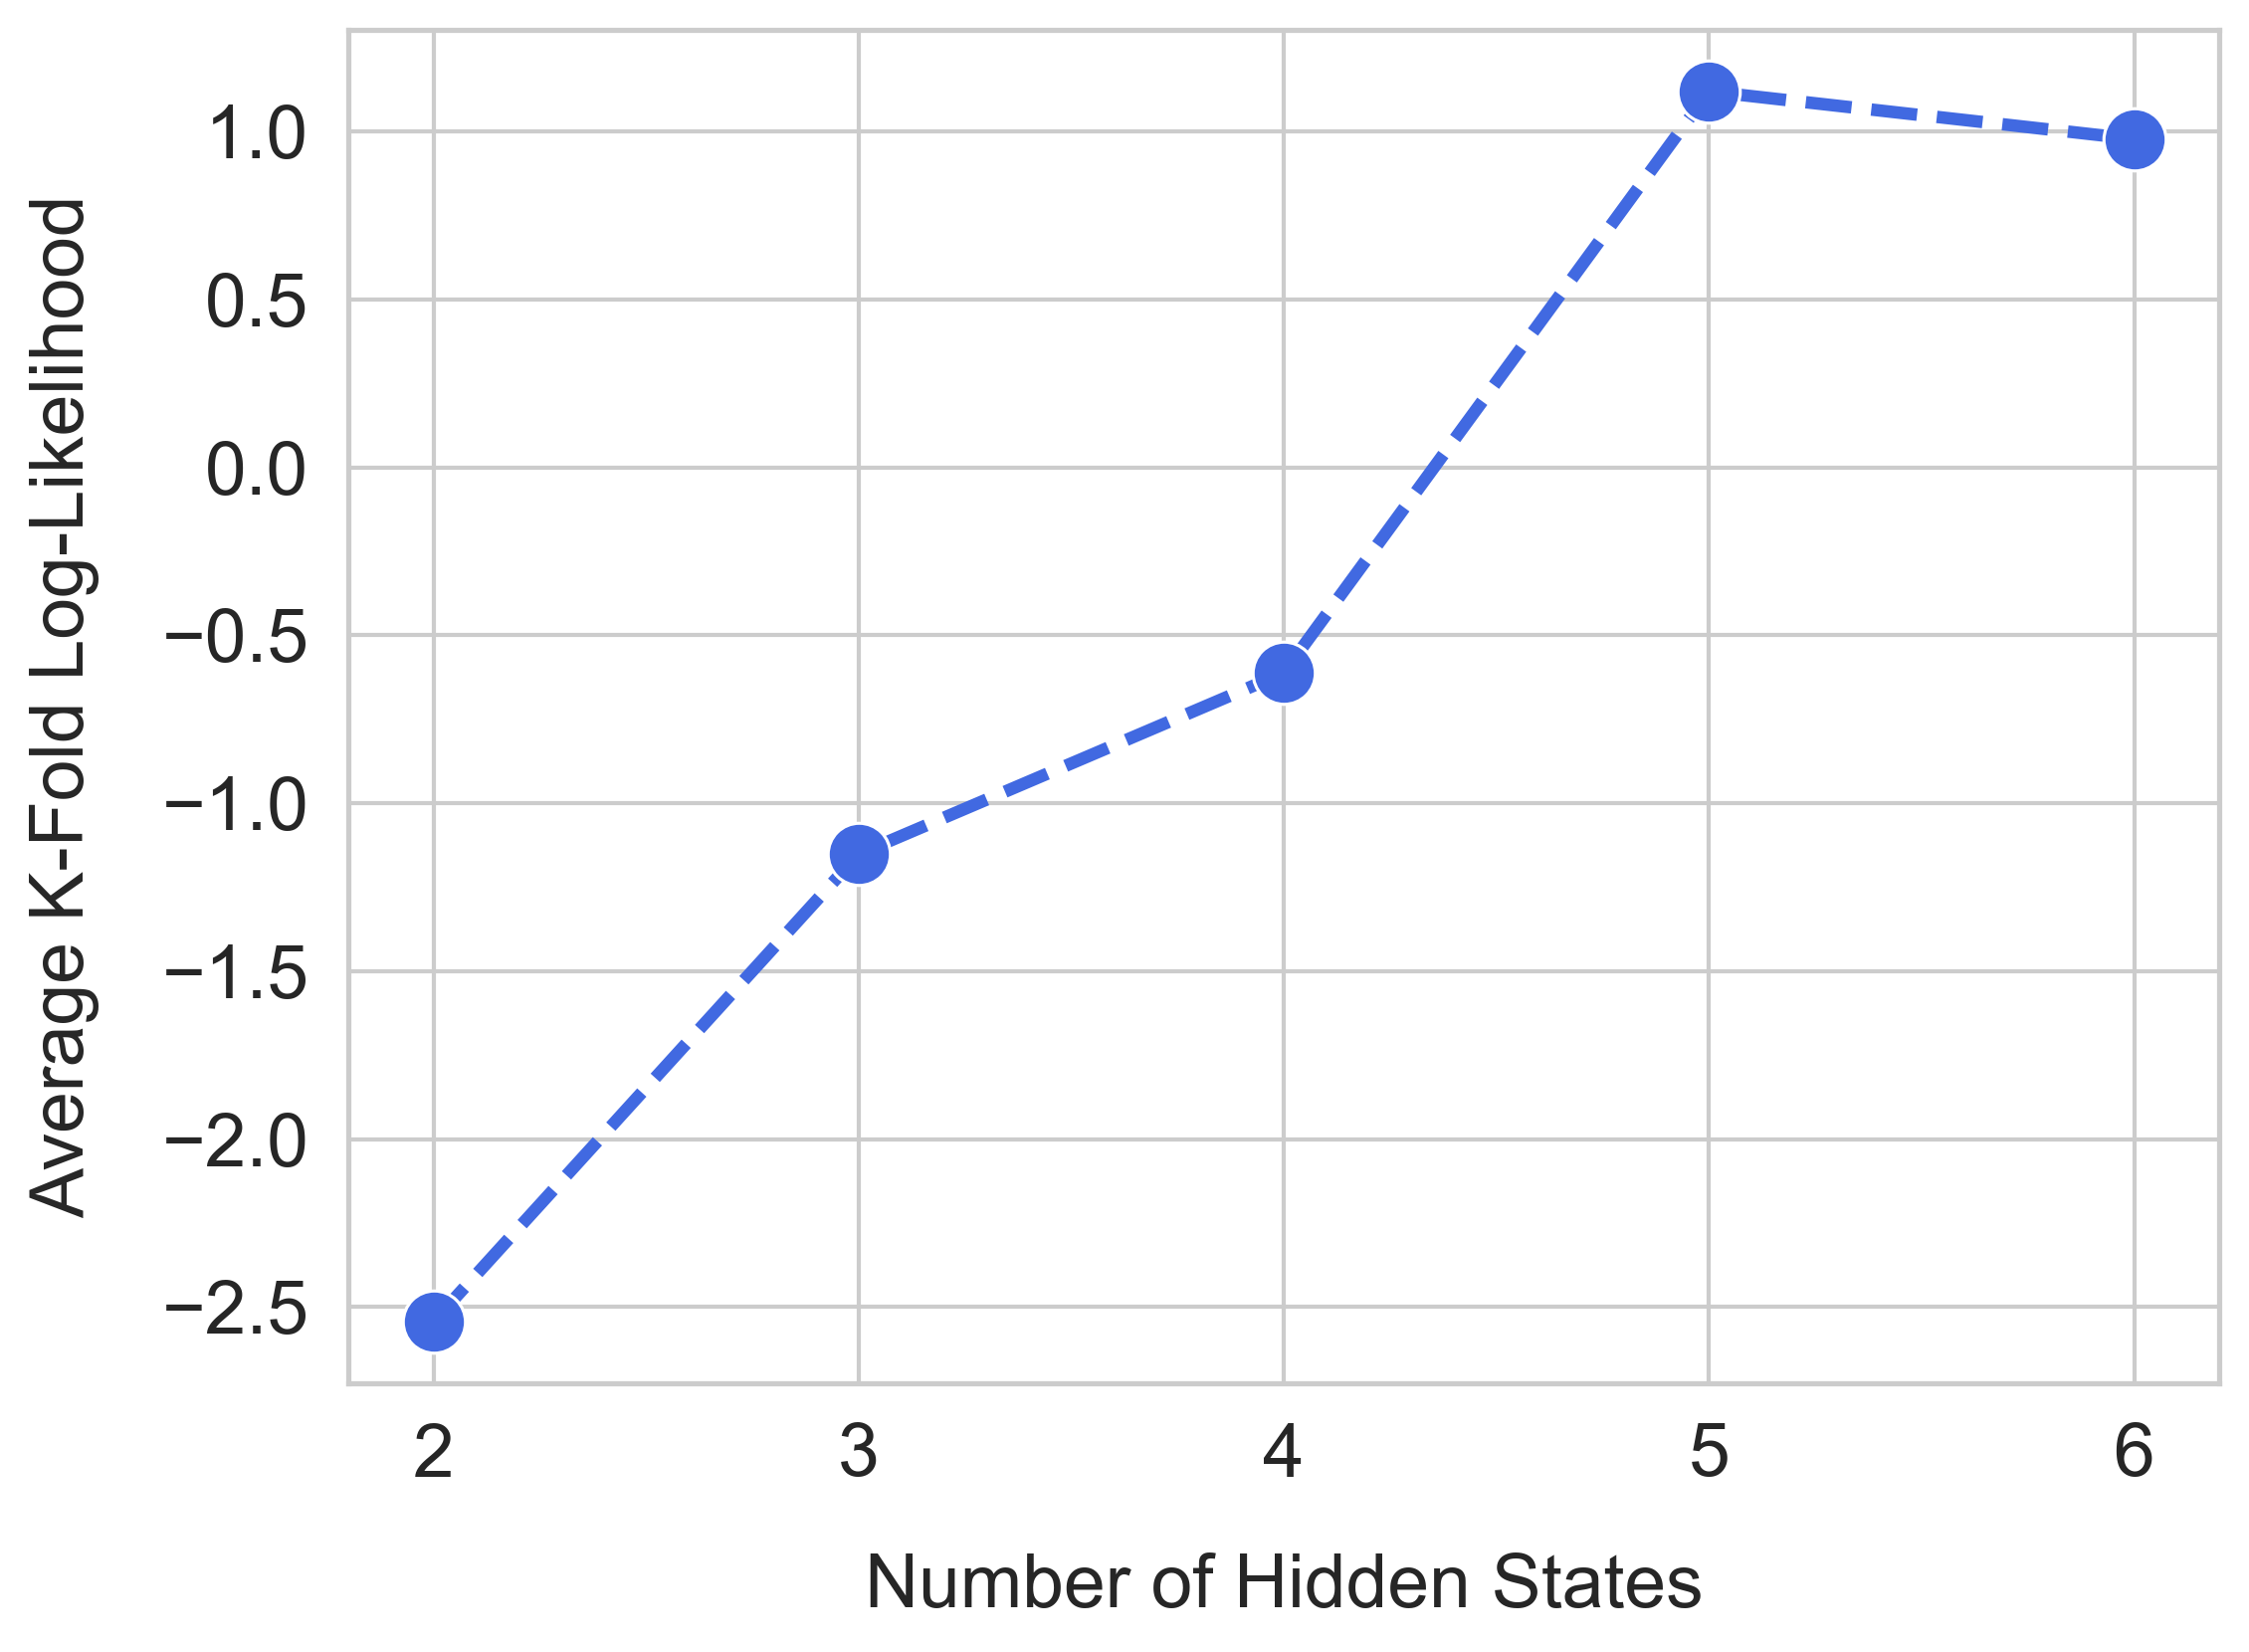

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


# Load data and prepare the dataset
data = pd.read_csv("data_1108__.csv")

# Separate segments by NaN rows and encode 'Code' column
segments = []
current_segment = []
for _, row in data.iterrows():
    if pd.isnull(row['Code']):
        if current_segment:
            segments.append(current_segment)
            current_segment = []
    else:
        current_segment.append(row)
if current_segment:
    segments.append(current_segment)

# Combine segments and encode 'Code'
all_segments = pd.concat([pd.DataFrame(seg) for seg in segments]).dropna()
label_encoder = LabelEncoder()
all_segments['Code_Encoded'] = label_encoder.fit_transform(all_segments['Code'])
encoded_data = all_segments[['Duration_Code', 'Frequency_Code', 'Code_Encoded']].dropna()

# Standardize the data
scaler = StandardScaler()
scaled_encoded_data = scaler.fit_transform(encoded_data)


# K-Fold Cross-Validation to find optimal hidden states within 2-5
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
state_range = range(2, 7)
kfold_scores_encoded = {n: [] for n in state_range}

for n in state_range:
    for train_index, test_index in kf.split(scaled_encoded_data):
        train_data, test_data = scaled_encoded_data[train_index], scaled_encoded_data[test_index]
        gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=2024)
        gmm.fit(train_data)
        log_likelihood = gmm.score(test_data)
        kfold_scores_encoded[n].append(log_likelihood)

# Calculate average score for each hidden state across folds including Code feature
average_kfold_scores_encoded = {n: np.mean(scores) for n, scores in kfold_scores_encoded.items()}

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting K-Fold Cross-Validation scores for each state count including Code
plt.figure(figsize=(8, 6), dpi=300)

# Enhanced line style with thicker line, larger markers, and vibrant color using Seaborn
sns.lineplot(x=state_range, y=list(average_kfold_scores_encoded.values()), 
             marker='o', linestyle='--', linewidth=3, markersize=15, color='royalblue')

plt.xlabel("Number of Hidden States", labelpad=15, fontsize=18)
plt.ylabel("Average K-Fold Log-Likelihood", labelpad=15, fontsize=18)
plt.xticks(state_range, fontsize=18)
plt.yticks(fontsize=18)

# Adjust layout to create additional padding
plt.tight_layout(pad=2.0)

# Save and display the plot

plt.savefig('Number_of_Hidden_states_seaborn.tif', format='tif')
plt.show()


# Optimal number of states including Code feature
optimal_states_encoded = max(average_kfold_scores_encoded, key=average_kfold_scores_encoded.get)

# Fit the GMM with optimal states
gmm_optimal_encoded = GaussianMixture(n_components=optimal_states_encoded, covariance_type='diag', random_state=42)
gmm_optimal_encoded.fit(scaled_encoded_data)
hidden_states_encoded = gmm_optimal_encoded.predict(scaled_encoded_data)

# Transition Matrix
transition_counts_encoded = np.zeros((optimal_states_encoded, optimal_states_encoded))
for i in range(1, len(hidden_states_encoded)):
    transition_counts_encoded[hidden_states_encoded[i - 1], hidden_states_encoded[i]] += 1
transition_probabilities_encoded = transition_counts_encoded / transition_counts_encoded.sum(axis=1, keepdims=True)

n_states=optimal_states_encoded


## hidden state heatmap

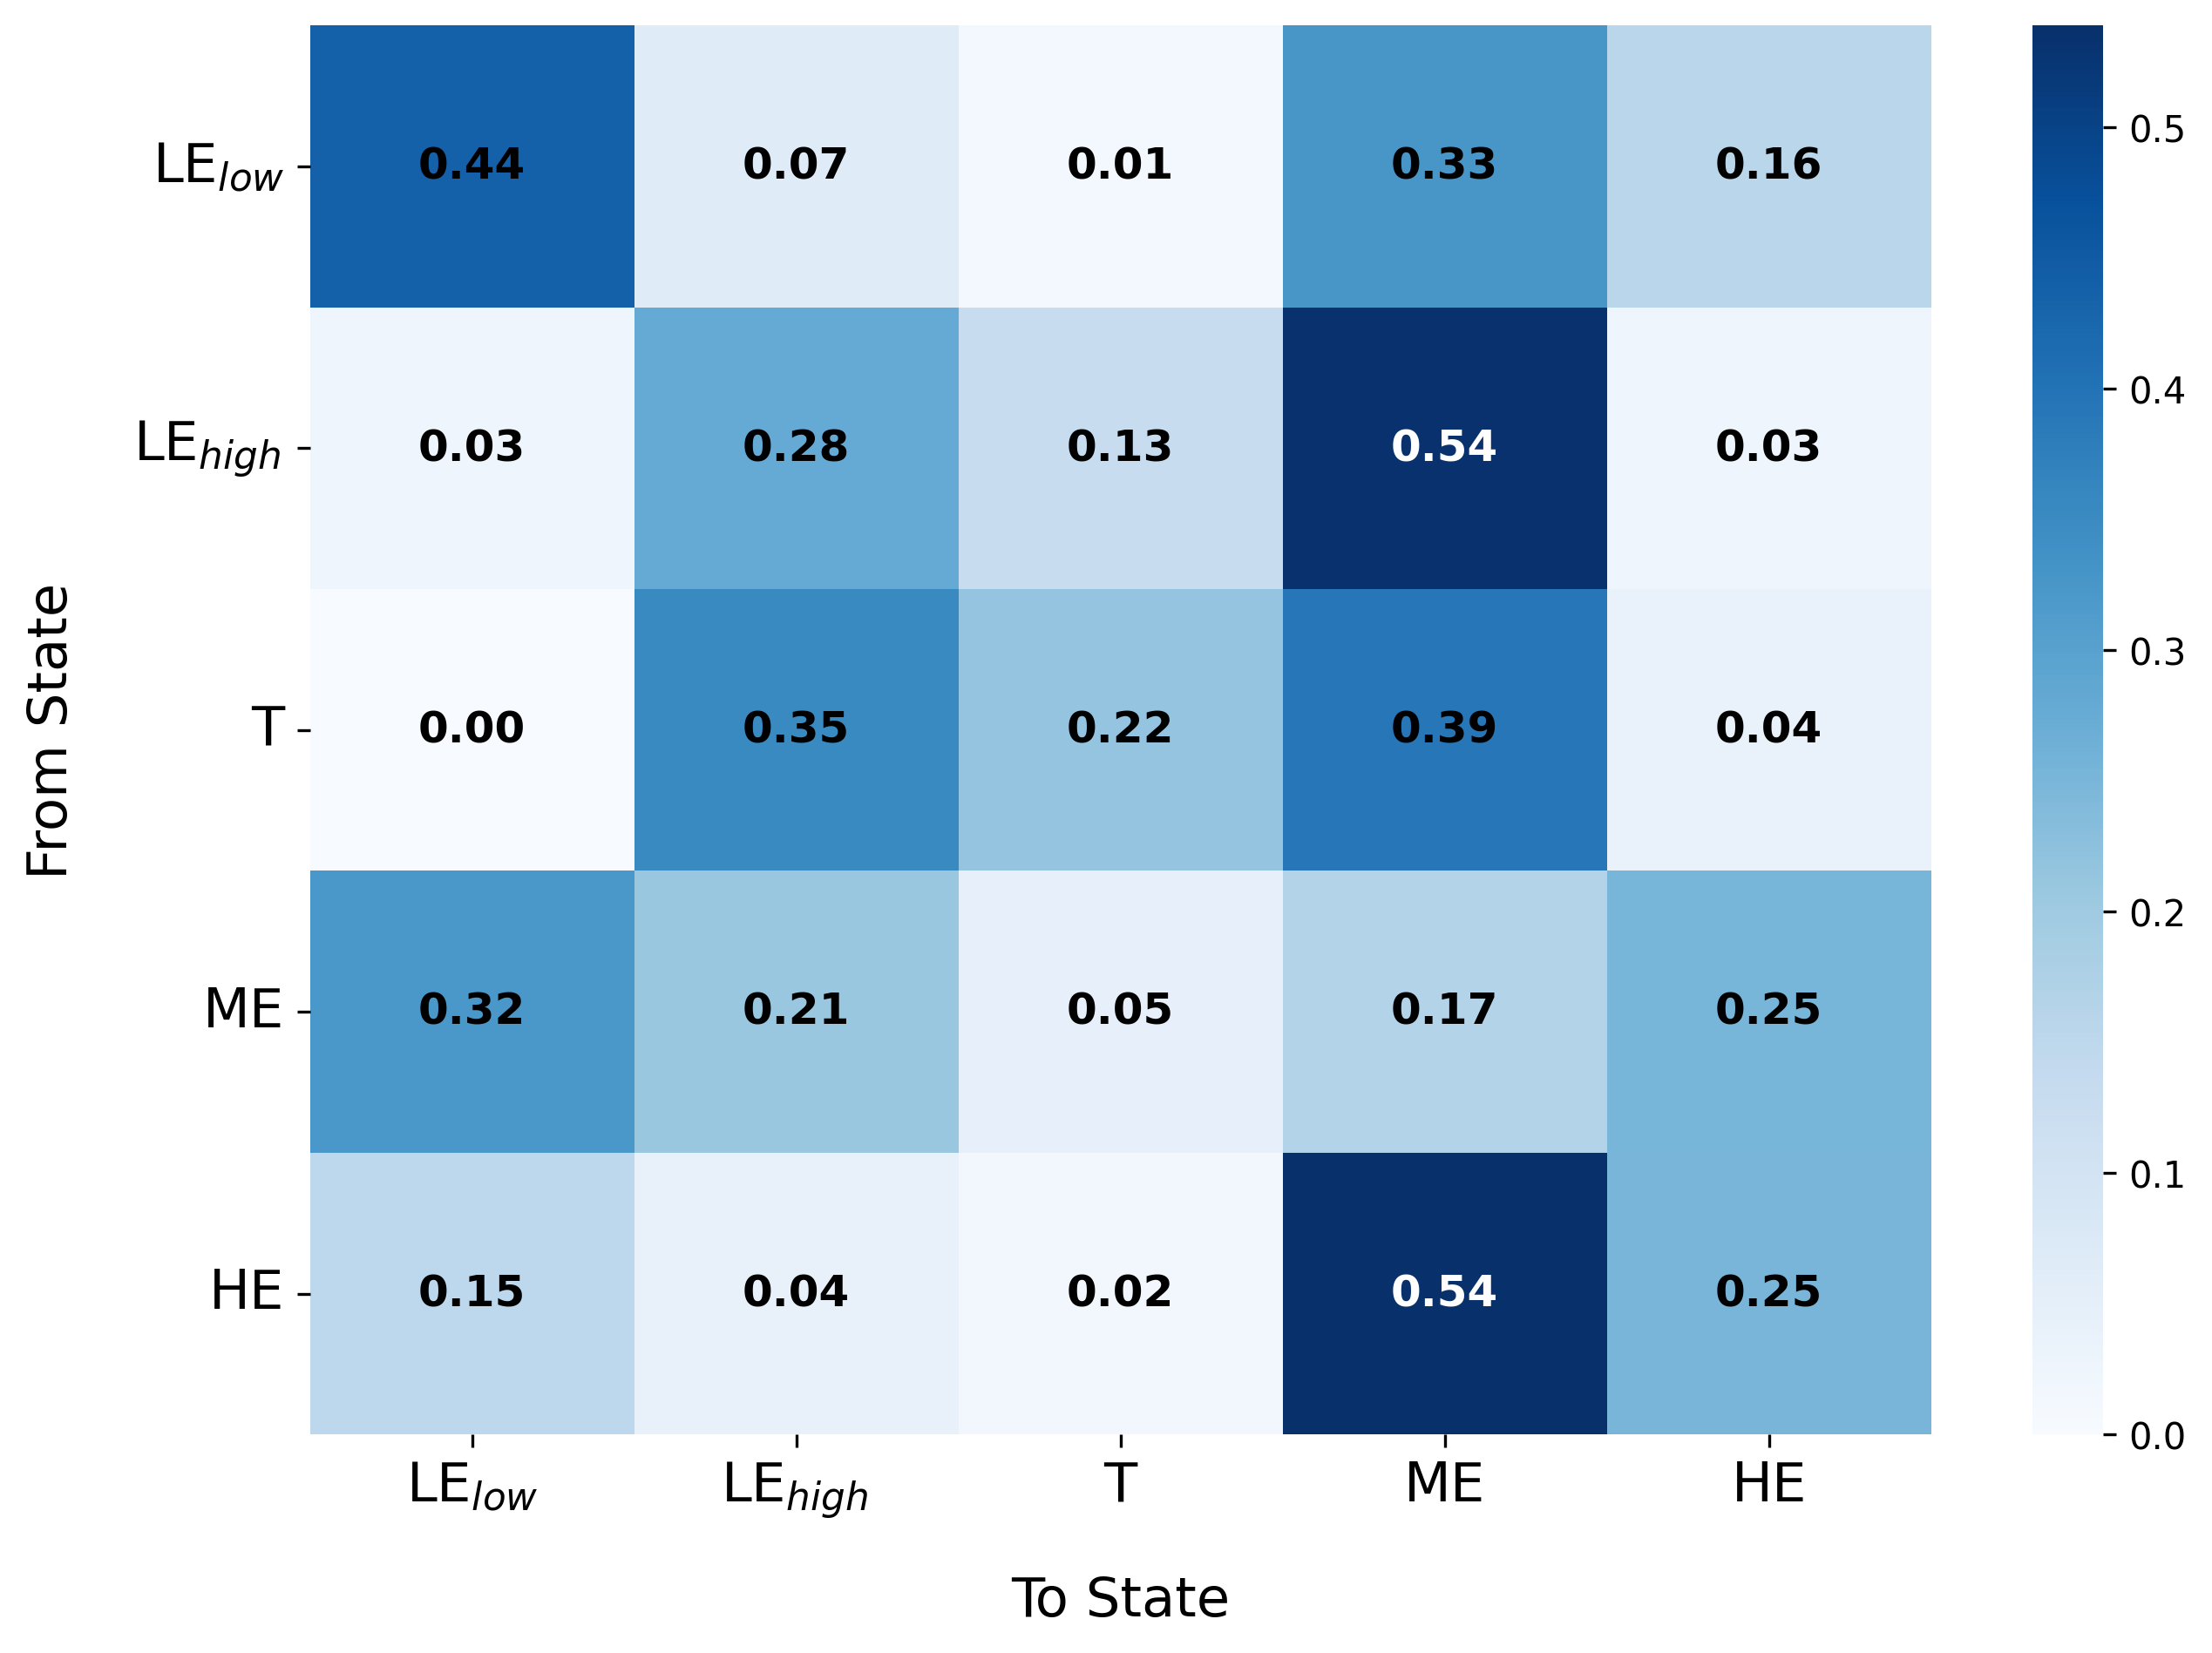

In [15]:
#Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

state_labels = ['LE$_{low}$', 'LE$_{high}$ ', 'T', 'ME', 'HE']
reordered_indices = [0, 4, 2, 1, 3]
transition_probabilities_reordered = transition_probabilities_encoded[reordered_indices, :][:, reordered_indices]

# Plotting the heatmap using seaborn with conditional font color for high probabilities
plt.figure(figsize=(10, 7), dpi=300)
sns.heatmap(
    transition_probabilities_reordered, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues",  
    xticklabels=state_labels, 
    yticklabels=state_labels, 
    annot_kws={"size": 12,"fontweight": "bold"}
)

# Set color for annotations conditionally
for text in plt.gca().texts:
    val = float(text.get_text())
    text.set_color("white" if val >= 0.54 else "black")

plt.xlabel("To State", labelpad=15, fontsize=15)
plt.ylabel("From State", labelpad=15, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.savefig("heatmap.tif", format='tif')
plt.show()


## Distribution Graph

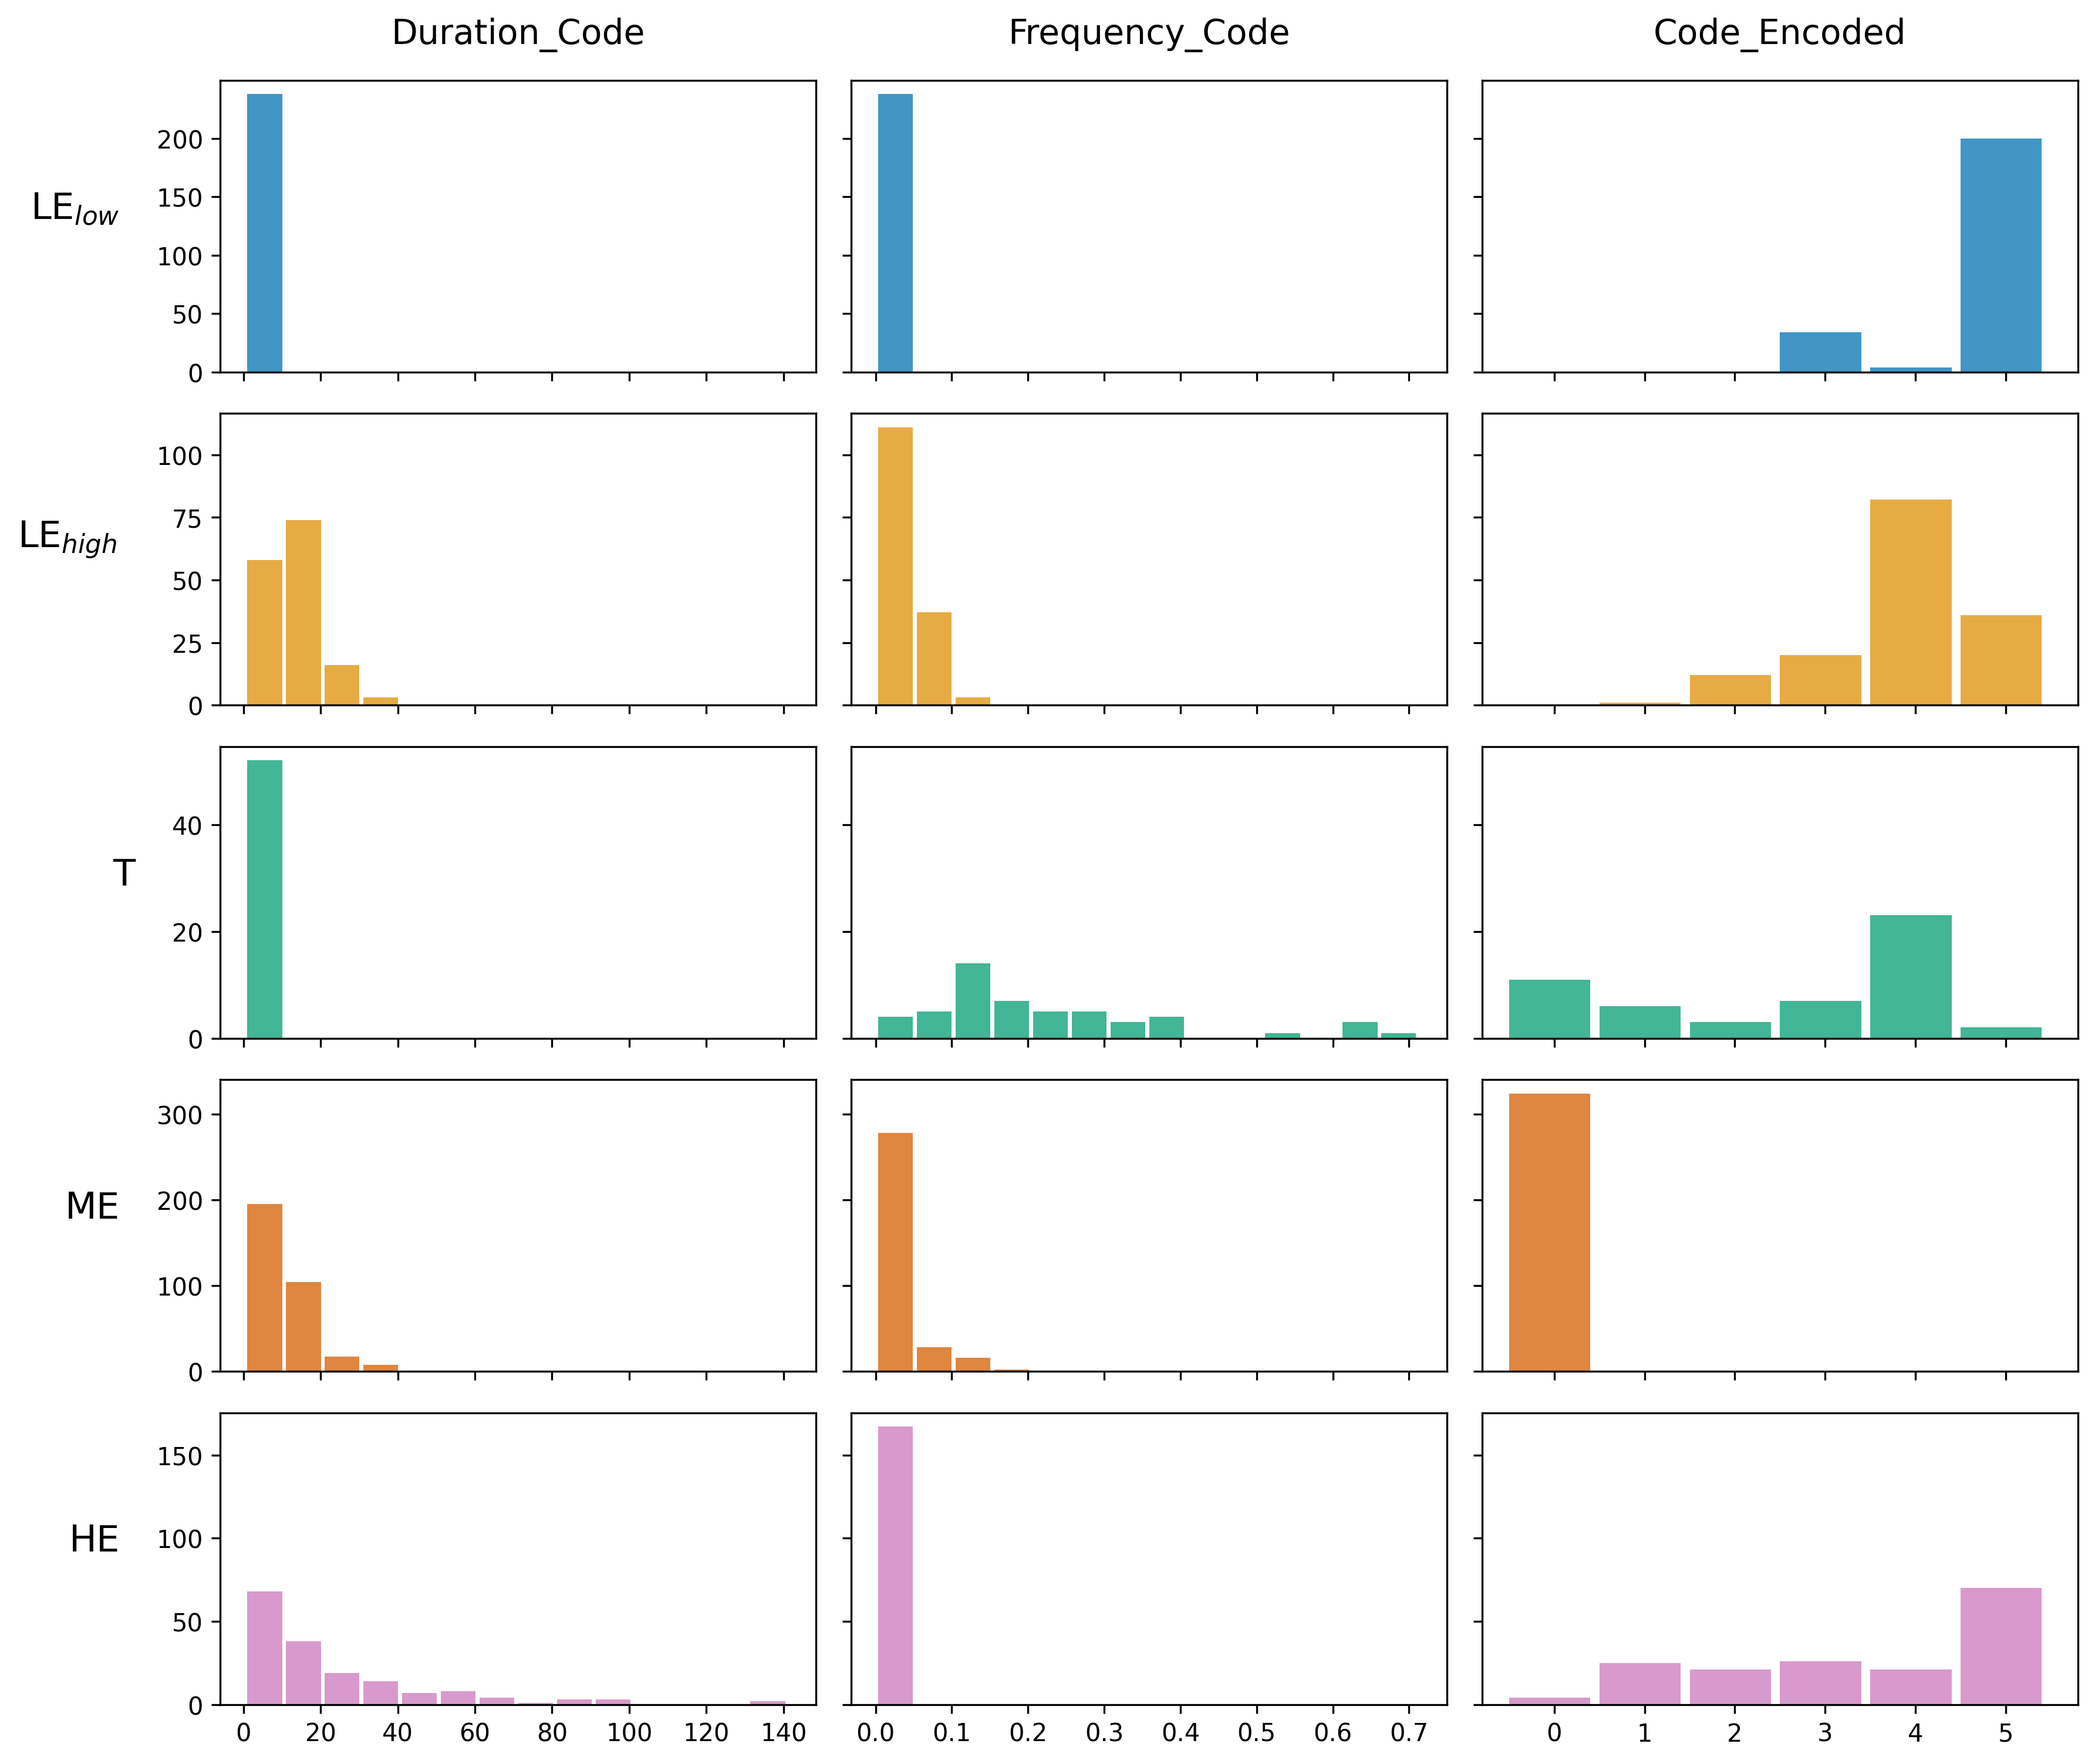

In [ ]:
# Plot distributions with reordered states and Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Set reordered state indices and labels with subscript notation as specified
reordered_states = [0, 4, 2, 1, 3]
state_labels = ['LE$_{low}$', 'LE$_{high}$ ', 'T', 'ME', 'HE']
features = ['Duration_Code', 'Frequency_Code', 'Code_Encoded']
all_segments['Hidden_State'] = hidden_states_encoded


# Set fixed bin edges for each feature to ensure consistency and integer alignment
duration_bins = np.linspace(all_segments['Duration_Code'].min(), all_segments['Duration_Code'].max(), 15)
frequency_bins = np.linspace(all_segments['Frequency_Code'].min(), all_segments['Frequency_Code'].max(), 15)
code_bins = np.arange(all_segments['Code_Encoded'].min(), all_segments['Code_Encoded'].max() + 1) - 0.5  # Ensuring bins from 0 to 5


# Adjust the plot to remove x-axis labels on the bottom row, remove bar edges, and add spacing between bars
fig, axes = plt.subplots(len(reordered_states), len(features), figsize=(12, 11), sharex='col', sharey='row')
fig.set_dpi(300)

# Refined color palette
fancy_colors = sns.color_palette("colorblind", len(reordered_states))

# Iterate over each state and feature to plot histograms and bar plots accordingly
for row, state in enumerate(reordered_states):
    state_data = all_segments[all_segments['Hidden_State'] == state]
    for col, feature in enumerate(features):
        if feature == 'Code_Encoded':
            # Use barplot for discrete data with spacing between bars
            sns.histplot(
                state_data[feature],
                bins=code_bins,
                color=fancy_colors[row],
                ax=axes[row, col],
                kde=False,
                discrete=True  # Mark as discrete
            )
        else:
            # Use histogram for continuous data with uniform binning
            bins = duration_bins if feature == 'Duration_Code' else frequency_bins
            sns.histplot(
                state_data[feature],
                bins=bins,
                color=fancy_colors[row],
                ax=axes[row, col],
                kde=False
            )
        
        # Set title for each feature on the top row
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14, pad=15)

    # Set the state label on the left side for each row
    axes[row, 0].set_ylabel(f"{state_labels[row]}", fontsize=15, rotation=0, labelpad=15, ha='right')

# Remove x-axis labels from the bottom row
for ax in axes[-1]:
    ax.set_xlabel("")

# Remove edges from bars and add slight spacing
for ax in axes.flatten():
    for patch in ax.patches:
        patch.set_edgecolor(None)  # Remove edge color for a cleaner look
        patch.set_width(patch.get_width() * 0.9)  # Add spacing by reducing bar width

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('distuibution_colorblind.tif', format='tif')
plt.show()